In [1]:
import math, re, os, random
from tqdm import tqdm
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import pathlib
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import load_model
import math

print("TF version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

!nvidia-smi

TF version 2.2.0
Sat Jul  4 12:54:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    32W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                       

In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!mkdir -p ~/.kaggle && cp '/content/drive/My Drive/kaggle.json' ~/.kaggle/ && chmod 600 ~/.kaggle/

In [5]:
!kaggle datasets download -d mylee2009/shopee-round-2-product-detection-challenge

100% 9.37G/9.38G [03:42<00:00, 41.3MB/s]
100% 9.38G/9.38G [03:42<00:00, 45.3MB/s]


In [6]:
!unzip -q shopee-round-2-product-detection-challenge.zip -d dataset

In [7]:
!rm shopee-round-2-product-detection-challenge.zip

In [8]:
#!cp -R '/content/drive/My Drive/Training' weight

In [3]:
MODEL_NAME = "Xception_unfrozen(380)"
IMG_HEIGHT = 380
IMG_WIDTH = 380
IMAGE_SIZE = (IMG_HEIGHT, IMG_WIDTH)
EPOCHS = 4
BATCH_SIZE = 64 * strategy.num_replicas_in_sync
SEED = 504433
SKIP_VALIDATION = False
SKIP_TRAINING = False
TTA_NUM = 1
ES_PATIENCE = 4
RLROP_PATIENCE = 5
DECAY_RATE = 0.525
DROPOUT_RATE = 0.2


random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [4]:
BASE_DIR = "dataset/" 
TRAIN_DIR = pathlib.Path(BASE_DIR + "train/train/")
TEST_DIR = pathlib.Path(BASE_DIR + "test/test/")

CLASS_NAMES = np.sort(np.array([item.name for item in TRAIN_DIR.glob('*')]))
#list_ds = tf.data.Dataset.list_files(str(TRAIN_DIR/'*/*'))
#IMAGE_COUNT = len(list(TRAIN_DIR.glob('*/*.jpg')))

In [5]:
print(CLASS_NAMES)

['00' '01' '02' '03' '04' '05' '06' '07' '08' '09' '10' '11' '12' '13'
 '14' '15' '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27'
 '28' '29' '30' '31' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41']


In [6]:
CLASSES = ['short dress',
  'long dress',
  'women top clothes',
  'women outerwear',
  'women pants (jeans)',
  'ring',
  'earring',
  'hat',
  'purse',
  'bag / case',
  'smartphone casing',
  'iphone ',
  'clock',
  'baby gear',
  'rice cooker',
  'coffee',
  'women shoes (flat)',
  'heels',
  'household electronic',
  'storage device',
  'berdoom furniture',
  'tennis / badminton equipment',
  'bicycle equipment',
  'handwear / footwear',
  'watches',
  'belt ',
  'earphone, headphone, mic',
  'toy vehicle',
  'man outerwear',
  'man pants',
  'man shoes',
  'snack',
  'personal protective equipment',
  'antiseptic',
  'skincare / cosmetic',
  'perfume',
  'hygiene equipment',
  'laptop & accessories',
  'tableware',
  'vase',
  'bathroom equipment',
  'living room furniture']

In [7]:
testdf = pd.read_csv("./dataset/test.csv",dtype=str)
testdf.head()

,filename,category
0,fd663cf2b6e1d7b02938c6aaae0a32d2.jpg,43
1,c7fd77508a8c355eaab0d4e10efd6b15.jpg,43
2,127f3e6d6e3491b2459812353f33a913.jpg,43
3,5ca4f2da11eda083064e6c36f37eeb81.jpg,43
4,46d681a542f2c71be017eef6aae23313.jpg,43


In [8]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                    validation_split=0)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

'''
                                                                    rotation_range=40,
                                                                    width_shift_range=0.2,
                                                                    height_shift_range=0.2,
                                                                    shear_range=0.2,
                                                                    zoom_range=0.2,
                                                                    horizontal_flip=True,
                                                                    fill_mode="nearest",
'''
train_ds = train_generator.flow_from_directory(directory=str(TRAIN_DIR),
                                                batch_size=BATCH_SIZE,
                                                shuffle=True,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                classes = list(CLASS_NAMES),
                                                seed = SEED,
                                                subset='training')
validation_ds = train_generator.flow_from_directory(directory=str(TRAIN_DIR),
                                                batch_size=BATCH_SIZE,
                                                shuffle=True,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                classes = list(CLASS_NAMES),
                                                seed = SEED,
                                                subset='validation')
test_ds1 = test_generator.flow_from_dataframe(dataframe = testdf,
                                              directory=str(TEST_DIR),
                                              x_col="filename",
                                              y_col=None,
                                              shuffle=False,
                                              class_mode=None,
                                              seed = SEED,
                                              target_size=(IMG_HEIGHT, IMG_WIDTH))
'''
VAL_SPLIT = 0.19
train_take = np.ceil(VAL_SPLIT * IMAGE_COUNT)

validation_ds = train_ds.skip(train_take)
train_ds = train_ds.take(train_take)

STEPS_PER_EPOCH = train_take // BATCH_SIZE
VAL_STEPS_PER_EPOCH = (IMAGE_COUNT-train_take) // BATCH_SIZE
'''

STEPS_PER_EPOCH = train_ds.samples // BATCH_SIZE
VAL_STEPS_PER_EPOCH = validation_ds.samples // BATCH_SIZE

Found 105392 images belonging to 42 classes.
Found 0 images belonging to 42 classes.
Found 12186 validated image filenames.


In [9]:
def get_training_dataset():
  return train_ds
def get_validation_dataset():
  return validation_ds
def get_test_dataset():
  return test_ds  

In [10]:
filepath = "/content/drive/Shared drives/Jogjas Island [Shopee CL]/Week2/Pretained_Fix/"+MODEL_NAME+"-{epoch:02d}-Best.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

es = EarlyStopping(monitor = 'loss', mode = 'min', patience = ES_PATIENCE, restore_best_weights = True, verbose = 1)
rlrop = ReduceLROnPlateau(monitor = 'loss', mode = 'min', patience = RLROP_PATIENCE, 
                        factor = DECAY_RATE, min_lr = 1e-6, verbose = 1)

In [11]:
!pip install -q efficientnet
import efficientnet.tfkeras as efn

In [12]:
with strategy.scope():

    # enet = efn.EfficientNetB6(input_shape=[*IMAGE_SIZE, 3], weights='noisy-student', include_top=False)
    
    #enet = tf.keras.applications.Xception(input_shape=[*IMAGE_SIZE, 3], weights='imagenet', include_top=False)

    #enet.trainable = True

    '''model1 = tf.keras.Sequential([
                enet,
                tf.keras.layers.GlobalAveragePooling2D(name="gap"),
                tf.keras.layers.Dropout(DROPOUT_RATE, name="dropout_out"),
                tf.keras.layers.Dense(len(CLASSES), activation='softmax', name="fc_out")
            ])'''
    METRICS = [ 
      tf.keras.metrics.CategoricalAccuracy("cat_acc"),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top5')
    ]
    # model1.load_weights("/content/drive/Shared drives/Jogjas Island [Shopee CL]/Week2/Pretained_Fix/Xception(512)-Final.hdf5")
    model1 = load_model('/content/drive/Shared drives/Jogjas Island [Shopee CL]/Week2/Pretained_Fix/Xception_unfrozen(380)-01-Best.hdf5')
    
    set_trainable = False
    for layer in model1.layers[0].layers:
        if layer.name == 'block13_sepconv1_act':
            set_trainable = True
        layer.trainable = set_trainable
    '''
    model1.compile(
        optimizer=tf.keras.optimizers.Adam(),
        # loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        loss = tfa.losses.SigmoidFocalCrossEntropy(),
        metrics=METRICS)
    '''
    model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 16, 16, 2048)      20861480  
_________________________________________________________________
gap (GlobalAveragePooling2D) (None, 2048)              0         
_________________________________________________________________
dropout_out (Dropout)        (None, 2048)              0         
_________________________________________________________________
fc_out (Dense)               (None, 42)                86058     
Total params: 20,947,538
Trainable params: 6,874,442
Non-trainable params: 14,073,096
_________________________________________________________________


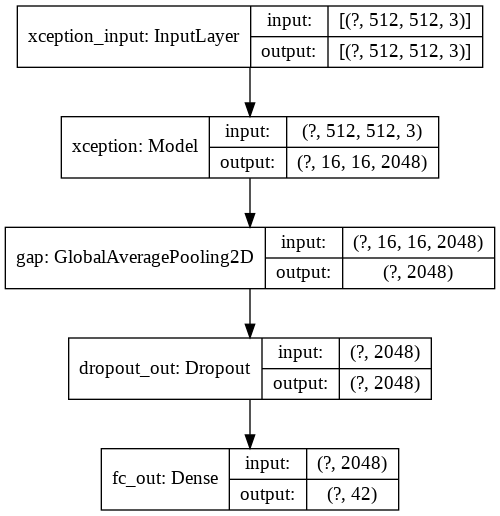

In [13]:
from tensorflow.keras.utils import plot_model
plot_model(model1, to_file='Xception.png', show_shapes=True)
from IPython.display import Image
Image(filename='Xception.png')

In [14]:
if not SKIP_TRAINING:
  if not SKIP_VALIDATION:
    history1 = model1.fit(train_ds, 
                        steps_per_epoch=STEPS_PER_EPOCH, 
                        epochs=EPOCHS, 
                        validation_data = validation_ds,
                        validation_steps = VAL_STEPS_PER_EPOCH,
                        verbose=1,
                        max_queue_size = 80,
                        workers = 128,
                        callbacks = [model_checkpoint_callback, es, rlrop])
  else:
        history1 = model1.fit(train_ds, 
                        steps_per_epoch=STEPS_PER_EPOCH, 
                        epochs=EPOCHS, 
                        verbose=1,
                        max_queue_size = 80,
                        workers = 128,
                        callbacks = [model_checkpoint_callback, es, rlrop])

Epoch 1/4
1646/1646 [==============================] - ETA: 0s - loss: 0.0205 - cat_acc: 0.9703 - auc: 0.9998 - top5: 0.9992
Epoch 00001: saving model to /content/drive/Shared drives/Jogjas Island [Shopee CL]/Week2/Pretained_Fix/Xception_unfrozen(380)-01-Best.hdf5
1646/1646 [==============================] - 1249s 759ms/step - loss: 0.0205 - cat_acc: 0.9703 - auc: 0.9998 - top5: 0.9992 - lr: 0.0010
Epoch 2/4
1646/1646 [==============================] - ETA: 0s - loss: 0.0247 - cat_acc: 0.9645 - auc: 0.9997 - top5: 0.9989
Epoch 00002: saving model to /content/drive/Shared drives/Jogjas Island [Shopee CL]/Week2/Pretained_Fix/Xception_unfrozen(380)-02-Best.hdf5
1646/1646 [==============================] - 1248s 758ms/step - loss: 0.0247 - cat_acc: 0.9645 - auc: 0.9997 - top5: 0.9989 - lr: 0.0010
Epoch 3/4
1646/1646 [==============================] - ETA: 0s - loss: 0.0197 - cat_acc: 0.9716 - auc: 0.9998 - top5: 0.9991
Epoch 00003: saving model to /content/drive/Shared drives/Jogjas Island

In [15]:
model1.save("/content/drive/Shared drives/Jogjas Island [Shopee CL]/Week2/Pretained_Fix/{0}-Final.hdf5".format(MODEL_NAME))

In [16]:
class_names = sorted(validation_ds.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21',
       '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32',
       '33', '34', '35', '36', '37', '38', '39', '40', '41'], dtype='<U2')

In [17]:
for image_batch, label_batch in train_ds:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (64, 380, 380, 3)
Label batch shape:  (64, 42)


In [18]:
predicted_batch = model1.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [19]:
label_id = np.argmax(label_batch, axis=-1)

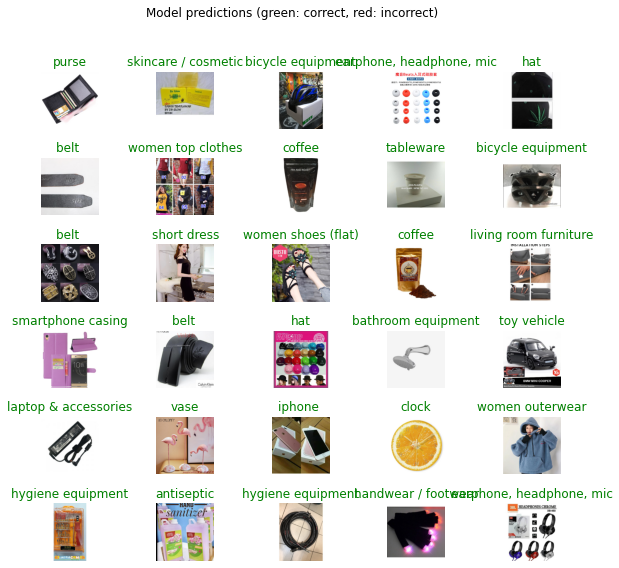

In [20]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(CLASSES[predicted_label_batch[n].astype(int)], color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [21]:
for image_test in test_ds1:
  print("Image batch shape: ", image_test.shape)
  break

Image batch shape:  (32, 380, 380, 3)


In [22]:
# load best model
model2 = tf.keras.Sequential([
                enet,
                tf.keras.layers.GlobalAveragePooling2D(name="gap"),
                tf.keras.layers.Dropout(DROPOUT_RATE, name="dropout_out"),
                tf.keras.layers.Dense(len(CLASSES), activation='softmax', name="fc_out")
            ])
METRICS = [ 
      tf.keras.metrics.CategoricalAccuracy("cat_acc"),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top5')
] 

model2.load_weights('/content/Xception-Best.hdf5')
    
model2.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=METRICS)
model2.summary()

NameError: ignored

In [ ]:
preds_tta = []
for i in tqdm(range(TTA_NUM)):
    test_ds1.reset()
    # predicted_test = model2.predict(test_ds, verbose=True)
    predicted_test = model1.predict(test_ds1, verbose=True)
    preds_tta.append(predicted_test)

In [ ]:
final_pred = np.mean(preds_tta, axis=0)
predicted_test_id = np.argmax(final_pred, axis=-1)
predicted_label_test = class_names[predicted_test_id]

In [ ]:
labels = (train_ds.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_test_id]

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_test[n])
  color = "green"
  plt.title(CLASSES[predictions[n].astype(int)], color=color)
  plt.axis('off')

In [ ]:
results=pd.DataFrame({"filename":test_ds1.filenames,
                      "category":predictions})
results.to_csv("results_{0}.csv".format(MODEL_NAME),index=False)